

# Regression-Master Template


Template for regression and time series based predictive modelling including the model development steps.


## Content

* [1. Problem Statement](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation](#3)
    * [4.1 Data Cleaning](#3.1)
    * [4.3.Feature Selection](#3.2)
    * [4.3.Data Transformation](#3.3) 
        * [4.3.1 Rescaling ](#3.3.1)
        * [4.3.2 Standardization](#3.3.2)
        * [4.3.3 Normalization](#3.3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
        * [5.3.1 Common Regression Models](#4.3.1)
        * [5.3.2 Ensemble Models](#4.3.2)
        * [5.3.3 Deep Learning Models](#4.3.3)  
    * [5.4. Time Series based Models-ARIMA and LSTM](#4.4)
        * [5.4.1 ARIMA Model](#4.4.1)
        * [5.4.2 LSTM Model](#4.4.2) 
* [6. Model Tuning and Grid Search](#5)
    * [6.1 Common Regression, Ensemble and DeepNNRegressor Grid Search](#5.1)
    * [6.2 ARIMA and LSTM Grid Search](#5.2) 
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Problem Statement

Our goal in this jupyter notebook is to under the following. A sample problem of stock price prediction in presented in this case study.
- How to work through a predictive modeling problem end-to-end. This notebook is applicable both for regression and classification problems.
- How to use data transforms to improve model performance.
- How to use algorithm tuning to improve model performance.
- How to use ensemble methods and tuning of ensemble methods to improve model performance.
- How to use deep Learning methods.
- Following Models are implemented

    * Linear Regression
    * Lasso
    * Elastic Net 
    * KNN
    * Decision Tree (CART)
    * Support Vector Machine 
    * Ada Boost
    * Gradient Boosting Method
    * Random Forest
    * Extra Trees
    * Neural Network - Shallow - Using sklearn
    * Deep Neural Network - Using Keras
- Time Series Models
    * ARIMA Model
    * LSTM - Using Keras
    

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

Using TensorFlow backend.


<a id='1.2'></a>
## 2.2. Loading the Data

In [2]:
# Get the data by webscapping using pandas datareader
return_period = 21


stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']

stk_data = web.DataReader(stk_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
idx_data = web.DataReader(idx_tickers, 'fred')

Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)
Y.name = Y.name[-1]+'_pred'

X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)

X4 = pd.concat([Y.diff(i) for i in [21, 63, 126,252]], axis=1).dropna()
X4.columns = ['1M', '3M', '6M', '1Y']

X = pd.concat([X1, X2, X3, X4], axis=1)

dataset = pd.concat([Y, X], axis=1).dropna()
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

#### Converting the data to supervised regression format
All the predictor variables are changed to lagged variable, as the t-1 value of the lagged variable will be used for prediction. 

In [5]:
def series_to_supervised(data, lag=1):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)    
    cols, names = list(), list()
    for i in range(lag, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg = pd.DataFrame(data.iloc[:,0]).join(agg)
    agg.dropna(inplace=True)
    return agg

In [6]:
dataset= series_to_supervised(dataset,1)

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [7]:
# shape
dataset.shape

(2252, 13)

In [8]:
# peek at data
pd.set_option('display.width', 100)
dataset.head(2)

,MSFT_pred,MSFT_pred(t-1),GOOGL(t-1),IBM(t-1),DEXJPUS(t-1),DEXUSUK(t-1),SP500(t-1),DJIA(t-1),VIXCLS(t-1),1M(t-1),3M(t-1),6M(t-1),1Y(t-1)
2011-01-04,-0.015788,-0.001431,0.055329,0.015718,-0.014243,-0.014930,0.037784,0.025045,-0.022460,-0.041166,-0.137312,-0.078563,0.076487
2011-01-05,-0.008248,-0.015788,0.049571,0.015426,-0.008988,-0.006013,0.037769,0.028544,-0.036162,-0.054624,-0.120203,-0.058879,0.090434


In [9]:
# types
pd.set_option('display.max_rows', 500)
dataset.dtypes

MSFT_pred         float64
MSFT_pred(t-1)    float64
GOOGL(t-1)        float64
IBM(t-1)          float64
DEXJPUS(t-1)      float64
DEXUSUK(t-1)      float64
SP500(t-1)        float64
DJIA(t-1)         float64
VIXCLS(t-1)       float64
1M(t-1)           float64
3M(t-1)           float64
6M(t-1)           float64
1Y(t-1)           float64
dtype: object

In [10]:
# describe data
pd.set_option('precision', 3)
dataset.describe()

,MSFT_pred,MSFT_pred(t-1),GOOGL(t-1),IBM(t-1),DEXJPUS(t-1),DEXUSUK(t-1),SP500(t-1),DJIA(t-1),VIXCLS(t-1),1M(t-1),3M(t-1),6M(t-1),1Y(t-1)
count,2252.000,2252.000,2252.000,2252.000,2.252e+03,2.252e+03,2252.000,2252.000,2252.000,2.252e+03,2.252e+03,2252.000,2252.000
mean,0.019,0.019,0.014,0.001,2.056e-03,-1.915e-03,0.008,0.007,0.005,4.086e-04,5.506e-04,0.001,0.004
std,0.058,0.058,0.067,0.063,2.503e-02,2.374e-02,0.043,0.045,0.265,8.737e-02,8.570e-02,0.077,0.081
min,-0.302,-0.302,-0.351,-0.461,-8.290e-02,-1.227e-01,-0.400,-0.444,-0.827,-4.272e-01,-3.467e-01,-0.327,-0.410
25%,-0.014,-0.014,-0.028,-0.031,-1.294e-02,-1.556e-02,-0.009,-0.010,-0.148,-5.193e-02,-4.780e-02,-0.047,-0.048
50%,0.023,0.023,0.017,0.004,9.865e-04,-7.240e-04,0.014,0.012,-0.021,5.407e-05,1.940e-03,-0.002,0.004
75%,0.052,0.052,0.053,0.039,1.489e-02,1.384e-02,0.030,0.031,0.120,4.945e-02,5.187e-02,0.045,0.056
max,0.244,0.244,0.271,0.230,1.023e-01,6.963e-02,0.203,0.214,1.799,5.407e-01,3.619e-01,0.275,0.230


<a id='2.2'></a>
## 3.2. Data Visualization

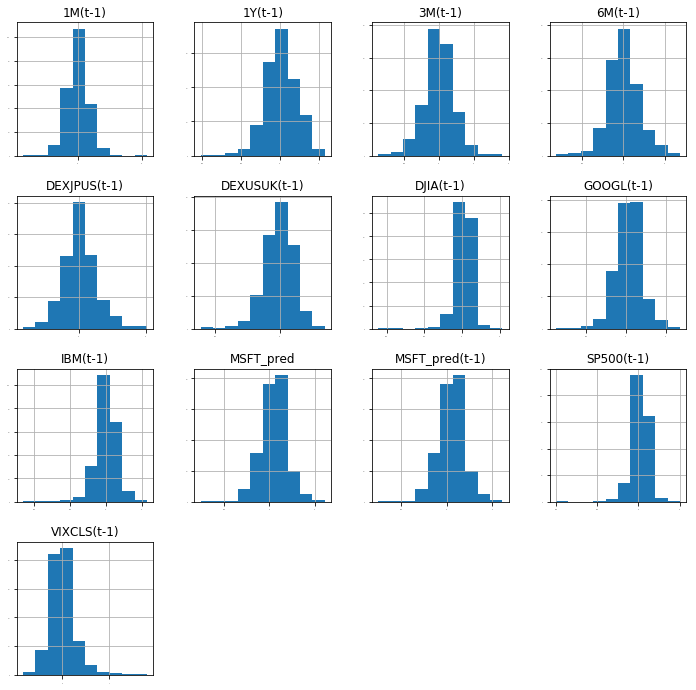

In [11]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

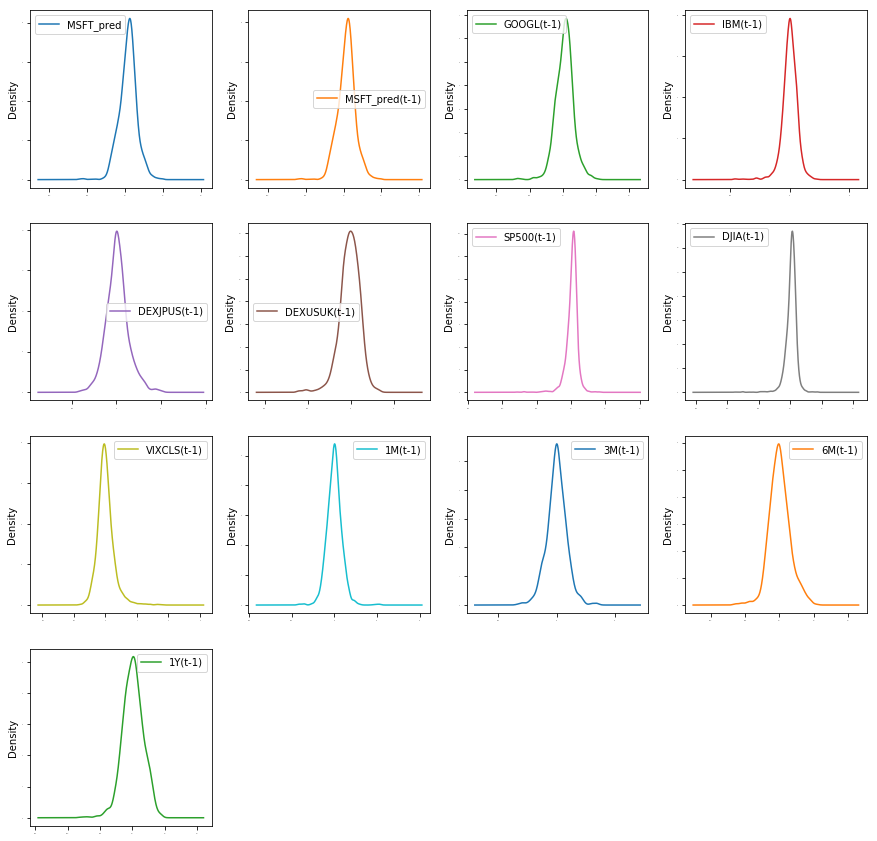

In [12]:
# density
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

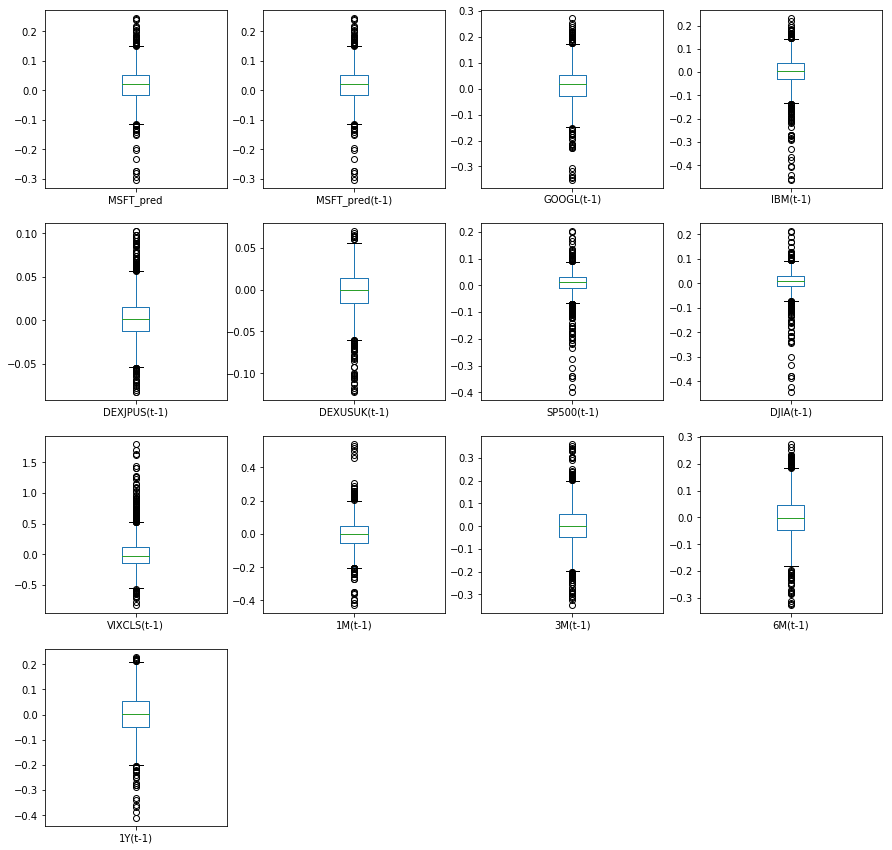

In [13]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

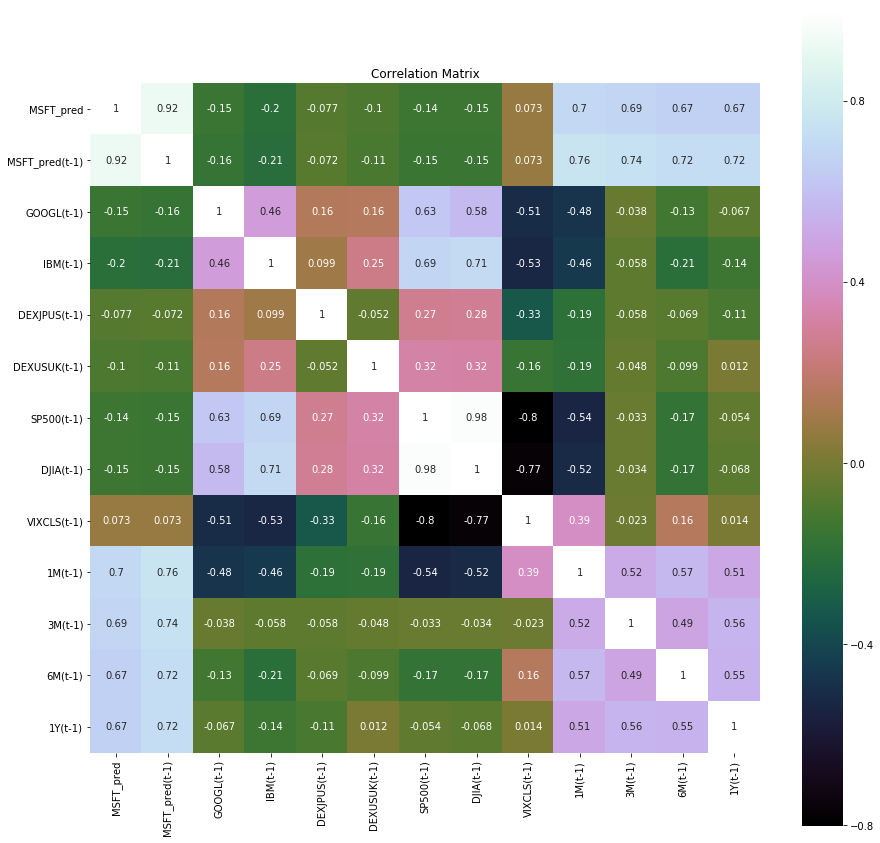

In [14]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

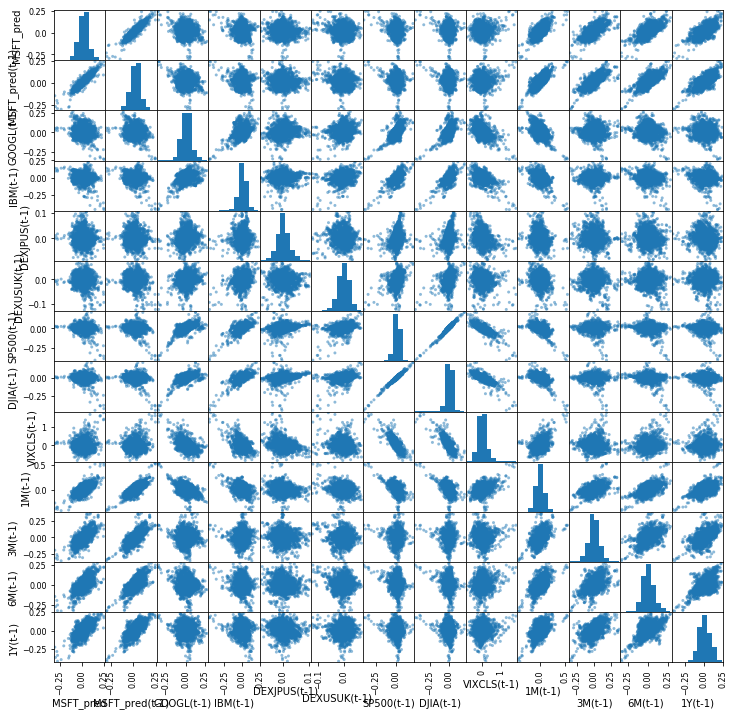

In [15]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

<a id='2.3'></a>
## 3.3. Time Series Analysis

Time series broken down into different time series comonent 

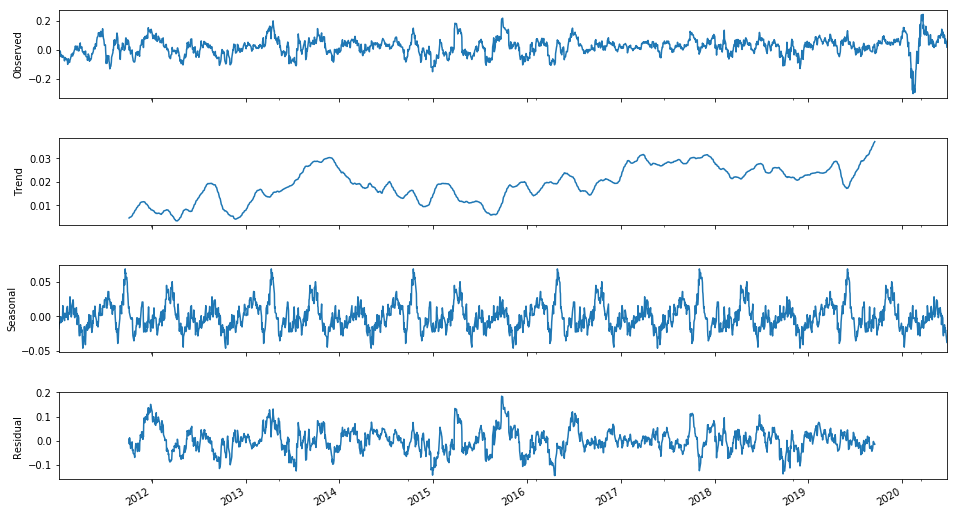

In [16]:
Y= dataset["MSFT_pred"]
res = sm.tsa.seasonal_decompose(Y,freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [17]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = False


Given that there are null values drop the rown contianing the null values.

In [18]:
# Drop the rows containing NA
#dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())

<a id='3.3'></a>
## 4.3. Feature Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.
The example below uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Dataset.

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(k=5)
bestfeatures

SelectKBest(k=5, score_func=<function f_classif at 0x0000021B972962F0>)

In [20]:
type(dataset)

pandas.core.frame.DataFrame

In [21]:
Y= dataset["MSFT_pred"]
X = dataset.loc[:, dataset.columns != 'MSFT_pred']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

             Specs    Score
0   MSFT_pred(t-1)  667.074
1       GOOGL(t-1)   15.767
10         6M(t-1)    7.466
9          3M(t-1)    6.491
4     DEXUSUK(t-1)    3.361
5       SP500(t-1)    1.716
8          1M(t-1)    1.656
7      VIXCLS(t-1)    1.441
11         1Y(t-1)    1.197
6        DJIA(t-1)    1.175


As it can be seen from the result above that t-1 is an important feature

<a id='3.4'></a>
## 4.4. Data Transformation

<a id='3.4.1'></a>
### 4.4.1. Rescale Data
When your data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale. Often this is referred to
as normalization and attributes are often rescaled into the range between 0 and 1.

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
rescaledX.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.551,0.653,0.690,0.371,0.560,0.726,0.713,0.306,0.399,0.296,0.413,0.760
1,0.525,0.644,0.689,0.399,0.607,0.726,0.719,0.301,0.385,0.320,0.446,0.781
2,0.538,0.648,0.687,0.459,0.537,0.734,0.723,0.294,0.389,0.329,0.454,0.773
3,0.514,0.635,0.713,0.382,0.538,0.724,0.718,0.307,0.347,0.331,0.418,0.753
4,0.533,0.633,0.696,0.395,0.580,0.715,0.716,0.312,0.379,0.350,0.509,0.764


<a id='3.4.2'></a>
### 4.4.2. Standardize Data
Standardization is a useful technique to transform attributes with a Gaussian distribution and
differing means and standard deviations to a standard Gaussian distribution with a mean of
0 and a standard deviation of 1.

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
StandardisedX.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.357,0.624,0.229,-0.651,-0.548,0.695,0.408,-0.104,-0.476,-1.609,-1.041,0.889
1,-0.604,0.538,0.224,-0.441,-0.173,0.694,0.486,-0.155,-0.630,-1.409,-0.784,1.061
2,-0.474,0.570,0.203,0.004,-0.740,0.797,0.552,-0.228,-0.583,-1.330,-0.719,0.999
3,-0.707,0.454,0.482,-0.565,-0.733,0.663,0.477,-0.092,-1.056,-1.315,-1.001,0.836
4,-0.526,0.439,0.299,-0.470,-0.385,0.533,0.439,-0.043,-0.695,-1.156,-0.287,0.922


<a id='3.4.3'></a>
### 4.4.1. Normalize Data
Normalizing in scikit-learn refers to rescaling each observation (row) to have a length of 1 (called
a unit norm or a vector with the length of 1 in linear algebra).

In [24]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(X)
NormalizedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
NormalizedX.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.007,0.281,0.080,-0.072,-0.076,0.192,0.127,-0.114,-0.209,-0.696,-0.398,0.388
1,-0.084,0.262,0.082,-0.048,-0.032,0.200,0.151,-0.191,-0.289,-0.636,-0.312,0.479
2,-0.044,0.277,0.076,0.012,-0.104,0.226,0.169,-0.297,-0.271,-0.608,-0.289,0.458
3,-0.111,0.224,0.162,-0.062,-0.099,0.186,0.144,-0.099,-0.469,-0.573,-0.386,0.369
4,-0.072,0.275,0.129,-0.062,-0.071,0.197,0.170,-0.041,-0.387,-0.632,-0.134,0.508


<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [25]:
# split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.

train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [26]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
#scoring = 'r2'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

<a id='4.3.1'></a>
### 5.3.1. Common Models

In [27]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
#Neural Network
models.append(('MLP', MLPRegressor()))

<a id='4.3.2'></a>
### 5.3.2. Ensemble Models

In [28]:
#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

<a id='4.3.3'></a>
### 5.3.3. Deep Learning Model-NN Regressor

In [29]:
#Running deep learning models and performing cross validation takes time
#Set the following Flag to 0 if the Deep LEarning Models Flag has to be disabled
EnableDeepLearningRegreesorFlag = 0

def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        #The number of hidden layers can be increased
        model.add(Dense(2, activation=activation))
        # Final output layer
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model   

In [30]:
#Add Deep Learning Regressor
if ( EnableDeepLearningRegreesorFlag == 1):
    models.append(('DNN', KerasRegressor(build_fn=create_model, epochs=100, batch_size=100, verbose=1)))       


### K-folds cross validation

In [31]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.000419 (0.000159)
LASSO: 0.003024 (0.001482)
EN: 0.003024 (0.001482)
KNN: 0.000934 (0.000363)
CART: 0.000988 (0.000280)
SVR: 0.001448 (0.000906)
MLP: 0.000734 (0.000242)
ABR: 0.000577 (0.000199)
GBR: 0.000460 (0.000179)
RFR: 0.000473 (0.000185)
ETR: 0.000472 (0.000192)


### Algorithm comparison

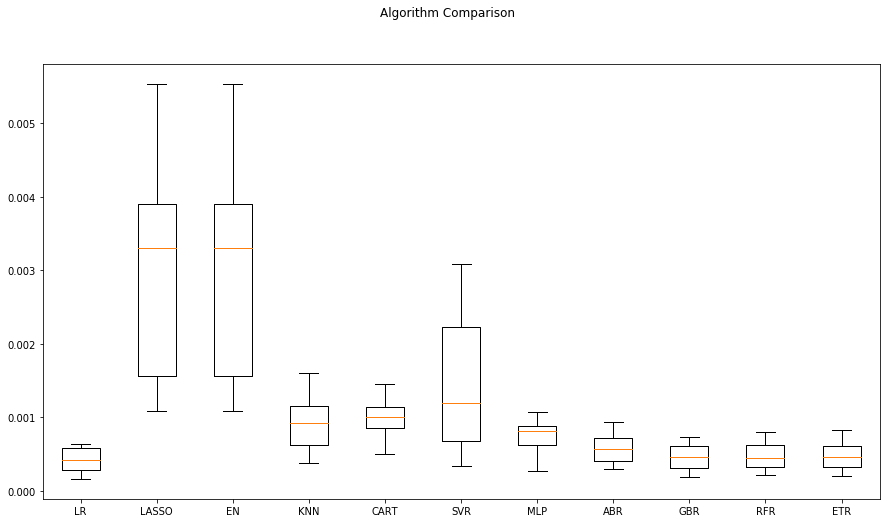

In [32]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

The chart shows MSE. Lower the MSE, better is the model performance.

<a id='4.4'></a>
## 5.4. Time Series based Models- ARIMA and LSTM

<a id='4.4.1'></a>
### 5.4.1 Time Series Model - ARIMA Model

In [33]:
#Preparing data for the ARIMAX Model, seperating endogeneous and exogenous variables
X_train_ARIMA=X_train.drop(['MSFT_pred(t-1)'], axis = 'columns' ).dropna()
X_validation_ARIMA=X_validation.drop(['MSFT_pred(t-1)'], axis = 'columns' ).dropna()
tr_len = len(X_train_ARIMA)
te_len = len(X_validation_ARIMA)
to_len = len (X)

In [34]:
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[1,0,0])
#modelARIMA= SARIMAX(Y_train,order=(1,1,0),seasonal_order=[1,0,0,0],exog = X_train_ARIMA)

model_fit = modelARIMA.fit()
#print(model_fit.summary())

In [35]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_validation_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_validation,predicted)
error_Test_ARIMA

0.0051007878797309026

In [36]:
#Add Cross validation if possible
# #model = build_model(_alpha=1.0, _l1_ratio=0.3)
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# scores = cross_val_score(modelARIMA, X_train, Y_train, cv=tscv, scoring=scoring)

<a id='4.4.2'></a>
### 5.4.2 LSTM Model

The data needs to be in 3D format for the LSTM model. So, Performing the data transform. 

In [37]:
X_train_LSTM, X_validation_LSTM = np.array(X_train), np.array(X_validation)
Y_train_LSTM, Y_validation_LSTM = np.array(Y_train), np.array(Y_validation)
X_train_LSTM= X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_validation_LSTM= X_validation_LSTM.reshape((X_validation_LSTM.shape[0], 1, X_validation_LSTM.shape[1]))
print(X_train_LSTM.shape, Y_train_LSTM.shape, X_validation_LSTM.shape, Y_validation_LSTM.shape)

(1801, 1, 12) (1801,) (451, 1, 12) (451,)


In [38]:
# design network
from matplotlib import pyplot

def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_validation_LSTM, Y_validation_LSTM),epochs=50, batch_size=72, verbose=0, shuffle=False)# plot history


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


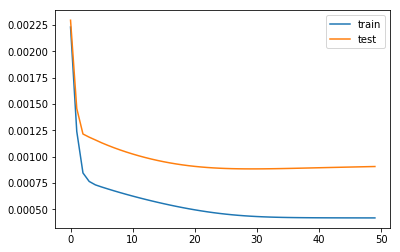

In [39]:
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [40]:
error_Training_LSTM = mean_squared_error(Y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_validation_LSTM)
error_Test_LSTM = mean_squared_error(Y_validation,predicted)
error_Test_LSTM

0.000906767112032725

### Overall Comparison of all the algorithms ( including Time Series Algorithms)

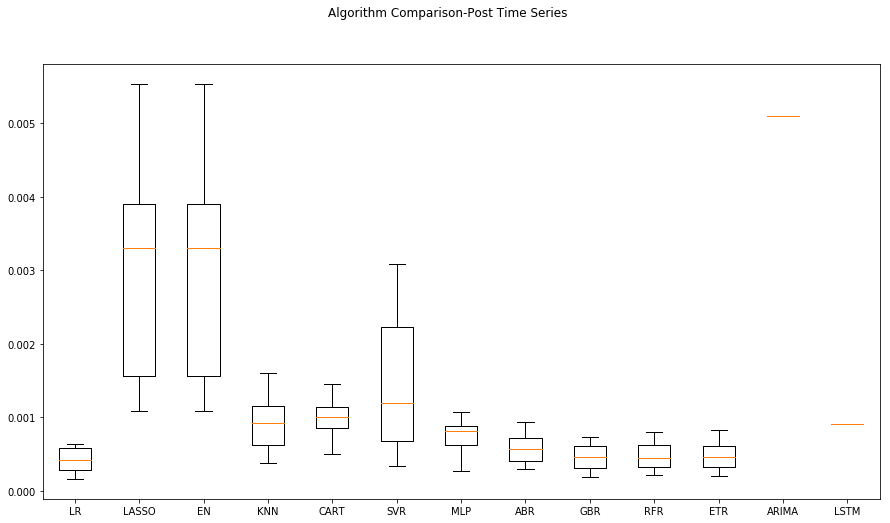

In [41]:
# compare algorithms
results.append(error_Test_ARIMA)
results.append(error_Test_LSTM)
names.append("ARIMA")
names.append("LSTM")
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison-Post Time Series')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Grid Search uses Cross validation which isn't appropriate for the time series models such as LSTM

<a id='5'></a>
# 6. Model Tuning and Grid Search
This section shown the Grid search for all the Machine Learning and time series models mentioned in the book.

<a id='5.1'></a>
### 6.1. Common Regression, Ensemble and DeepNNRegressor Grid Search


In [42]:
# 1. Grid search : LinearRegression
'''
fit_intercept : boolean, optional, default True
    whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (e.g. data is expected to be already centered).
'''
param_grid = {'fit_intercept': [True, False]}
model = LinearRegression()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000419 using {'fit_intercept': True}
-0.000419 (0.000159) with: {'fit_intercept': True}
-0.000419 (0.000158) with: {'fit_intercept': False}


In [43]:
# 2. Grid search : Lasso
'''
alpha : float, optional
    Constant that multiplies the L1 term. Defaults to 1.0.
    ``alpha = 0`` is equivalent to an ordinary least square, solved
    by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.
''' 
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5]}
model = Lasso()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.003024 using {'alpha': 0.01}
-0.003024 (0.001482) with: {'alpha': 0.01}
-0.003024 (0.001482) with: {'alpha': 0.1}
-0.003024 (0.001482) with: {'alpha': 0.3}
-0.003024 (0.001482) with: {'alpha': 0.7}
-0.003024 (0.001482) with: {'alpha': 1}
-0.003024 (0.001482) with: {'alpha': 1.5}
-0.003024 (0.001482) with: {'alpha': 3}
-0.003024 (0.001482) with: {'alpha': 5}


In [44]:
# 3. Grid Search : ElasticNet
'''
alpha : float, optional
    Constant that multiplies the penalty terms. Defaults to 1.0.
    See the notes for the exact mathematical meaning of this
    parameter.``alpha = 0`` is equivalent to an ordinary least square,
    solved by the :class:`LinearRegression` object. For numerical
    reasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.
    Given this, you should use the :class:`LinearRegression` object.

l1_ratio : float
    The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For
    ``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` it
    is an L1 penalty.  For ``0 < l1_ratio < 1``, the penalty is a
    combination of L1 and L2.
'''
param_grid = {'alpha': [0.01, 0.1, 0.3, 0.7, 1, 1.5, 3, 5],
              'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]}
model = ElasticNet()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.001091 using {'alpha': 0.01, 'l1_ratio': 0.01}
-0.001091 (0.000493) with: {'alpha': 0.01, 'l1_ratio': 0.01}
-0.001526 (0.000750) with: {'alpha': 0.01, 'l1_ratio': 0.1}
-0.002986 (0.001506) with: {'alpha': 0.01, 'l1_ratio': 0.3}
-0.003024 (0.001482) with: {'alpha': 0.01, 'l1_ratio': 0.5}
-0.003024 (0.001482) with: {'alpha': 0.01, 'l1_ratio': 0.7}
-0.003024 (0.001482) with: {'alpha': 0.01, 'l1_ratio': 0.9}
-0.003024 (0.001482) with: {'alpha': 0.01, 'l1_ratio': 0.99}
-0.002616 (0.001297) with: {'alpha': 0.1, 'l1_ratio': 0.01}
-0.003024 (0.001482) with: {'alpha': 0.1, 'l1_ratio': 0.1}
-0.003024 (0.001482) with: {'alpha': 0.1, 'l1_ratio': 0.3}
-0.003024 (0.001482) with: {'alpha': 0.1, 'l1_ratio': 0.5}
-0.003024 (0.001482) with: {'alpha': 0.1, 'l1_ratio': 0.7}
-0.003024 (0.001482) with: {'alpha': 0.1, 'l1_ratio': 0.9}
-0.003024 (0.001482) with: {'alpha': 0.1, 'l1_ratio': 0.99}
-0.003022 (0.001483) with: {'alpha': 0.3, 'l1_ratio': 0.01}
-0.003024 (0.001482) with: {'alpha': 0.3, 'l1_r

In [45]:

# 4. Grid search : KNeighborsRegressor 
'''
n_neighbors : int, optional (default = 5)
    Number of neighbors to use by default for :meth:`kneighbors` queries.
'''
param_grid = {'n_neighbors': [1,3,5,7,9,11,13,15,17,19,21]}
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: -0.000860 using {'n_neighbors': 17}
-0.001571 (0.000373) with: {'n_neighbors': 1}
-0.001040 (0.000358) with: {'n_neighbors': 3}
-0.000934 (0.000363) with: {'n_neighbors': 5}
-0.000886 (0.000349) with: {'n_neighbors': 7}
-0.000877 (0.000358) with: {'n_neighbors': 9}
-0.000871 (0.000353) with: {'n_neighbors': 11}
-0.000865 (0.000361) with: {'n_neighbors': 13}
-0.000864 (0.000358) with: {'n_neighbors': 15}
-0.000860 (0.000361) with: {'n_neighbors': 17}
-0.000865 (0.000365) with: {'n_neighbors': 19}
-0.000864 (0.000372) with: {'n_neighbors': 21}


In [46]:
# 5. Grid search : DecisionTreeRegressor 
'''
min_samples_split : int, float, optional (default=2)
    The minimum number of samples required to split an internal node:

    - If int, then consider `min_samples_split` as the minimum number.
    - If float, then `min_samples_split` is a percentage and
      `ceil(min_samples_split * n_samples)` are the minimum
      number of samples for each split.
'''
param_grid={'min_samples_split': [2,3,4,5,6,7,8,9,10]}
model = DecisionTreeRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000780 using {'min_samples_split': 10}
-0.000928 (0.000256) with: {'min_samples_split': 2}
-0.000932 (0.000322) with: {'min_samples_split': 3}
-0.000919 (0.000266) with: {'min_samples_split': 4}
-0.000907 (0.000300) with: {'min_samples_split': 5}
-0.000878 (0.000240) with: {'min_samples_split': 6}
-0.000866 (0.000266) with: {'min_samples_split': 7}
-0.000872 (0.000249) with: {'min_samples_split': 8}
-0.000826 (0.000210) with: {'min_samples_split': 9}
-0.000780 (0.000196) with: {'min_samples_split': 10}


In [47]:
# 6. Grid search : SVR 
'''
C : float, optional (default=1.0)
    Penalty parameter C of the error term.

epsilon : float, optional (default=0.1)
     Epsilon in the epsilon-SVR model. It specifies the epsilon-tube
     within which no penalty is associated in the training loss function
     with points predicted within a distance epsilon from the actual
     value.
gamma : float, optional (default='auto')
    Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    If gamma is 'auto' then 1/n_features will be used instead.
'''
param_grid={'C': [0.01, 0.03,0.1,0.3,1,3,10,30,100],
            'gamma': [0.001, 0.01, 0.1, 1]},
            #'epslion': [0.01, 0.1, 1]}
model = SVR()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000968 using {'C': 100, 'gamma': 0.01}
-0.002999 (0.001492) with: {'C': 0.01, 'gamma': 0.001}
-0.002928 (0.001476) with: {'C': 0.01, 'gamma': 0.01}
-0.002514 (0.001316) with: {'C': 0.01, 'gamma': 0.1}
-0.001806 (0.000995) with: {'C': 0.01, 'gamma': 1}
-0.002982 (0.001488) with: {'C': 0.03, 'gamma': 0.001}
-0.002792 (0.001428) with: {'C': 0.03, 'gamma': 0.01}
-0.002106 (0.001121) with: {'C': 0.03, 'gamma': 0.1}
-0.001586 (0.000873) with: {'C': 0.03, 'gamma': 1}
-0.002928 (0.001476) with: {'C': 0.1, 'gamma': 0.001}
-0.002509 (0.001311) with: {'C': 0.1, 'gamma': 0.01}
-0.001779 (0.000943) with: {'C': 0.1, 'gamma': 0.1}
-0.001240 (0.000610) with: {'C': 0.1, 'gamma': 1}
-0.002791 (0.001427) with: {'C': 0.3, 'gamma': 0.001}
-0.002097 (0.001120) with: {'C': 0.3, 'gamma': 0.01}
-0.001542 (0.000810) with: {'C': 0.3, 'gamma': 0.1}
-0.001218 (0.000536) with: {'C': 0.3, 'gamma': 1}
-0.002508 (0.001310) with: {'C': 1, 'gamma': 0.001}
-0.001776 (0.000941) with: {'C': 1, 'gamma': 0.01}
-0.00

In [48]:
# 7. Grid search : MLPRegressor 
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000801 using {'hidden_layer_sizes': (50,)}
-0.001169 (0.000496) with: {'hidden_layer_sizes': (20,)}
-0.000801 (0.000337) with: {'hidden_layer_sizes': (50,)}
-0.000994 (0.000372) with: {'hidden_layer_sizes': (20, 20)}
-0.000880 (0.000292) with: {'hidden_layer_sizes': (20, 30, 20)}


In [49]:
# 8. Grid search : RandomForestRegressor 
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000470 using {'n_estimators': 400}
-0.000479 (0.000189) with: {'n_estimators': 50}
-0.000470 (0.000182) with: {'n_estimators': 100}
-0.000471 (0.000183) with: {'n_estimators': 150}
-0.000470 (0.000182) with: {'n_estimators': 200}
-0.000471 (0.000183) with: {'n_estimators': 250}
-0.000473 (0.000185) with: {'n_estimators': 300}
-0.000471 (0.000180) with: {'n_estimators': 350}
-0.000470 (0.000181) with: {'n_estimators': 400}


In [50]:

# 9. Grid search : GradientBoostingRegressor 
'''
n_estimators:

    The number of boosting stages to perform. Gradient boosting
    is fairly robust to over-fitting so a large number usually
    results in better performance.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000446 using {'n_estimators': 50}
-0.000446 (0.000174) with: {'n_estimators': 50}
-0.000461 (0.000182) with: {'n_estimators': 100}
-0.000474 (0.000186) with: {'n_estimators': 150}
-0.000484 (0.000191) with: {'n_estimators': 200}
-0.000492 (0.000193) with: {'n_estimators': 250}
-0.000498 (0.000193) with: {'n_estimators': 300}
-0.000505 (0.000196) with: {'n_estimators': 350}
-0.000511 (0.000195) with: {'n_estimators': 400}


In [51]:
# 10. Grid search : ExtraTreesRegressor 
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000470 using {'n_estimators': 400}
-0.000472 (0.000186) with: {'n_estimators': 50}
-0.000473 (0.000186) with: {'n_estimators': 100}
-0.000474 (0.000189) with: {'n_estimators': 150}
-0.000472 (0.000189) with: {'n_estimators': 200}
-0.000471 (0.000190) with: {'n_estimators': 250}
-0.000471 (0.000190) with: {'n_estimators': 300}
-0.000470 (0.000189) with: {'n_estimators': 350}
-0.000470 (0.000188) with: {'n_estimators': 400}


In [52]:
# 11. Grid search : AdaBoostRegre
'''
n_estimators : integer, optional (default=50)
    The maximum number of estimators at which boosting is terminated.
    In case of perfect fit, the learning procedure is stopped early.

learning_rate : float, optional (default=1.)
    Learning rate shrinks the contribution of each regressor by
    ``learning_rate``. There is a trade-off between ``learning_rate`` and
    ``n_estimators``.
''' 
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400],
             'learning_rate': [1, 2, 3]}
model = AdaBoostRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000574 using {'learning_rate': 1, 'n_estimators': 50}
-0.000574 (0.000189) with: {'learning_rate': 1, 'n_estimators': 50}
-0.000607 (0.000195) with: {'learning_rate': 1, 'n_estimators': 100}
-0.000613 (0.000181) with: {'learning_rate': 1, 'n_estimators': 150}
-0.000625 (0.000180) with: {'learning_rate': 1, 'n_estimators': 200}
-0.000634 (0.000180) with: {'learning_rate': 1, 'n_estimators': 250}
-0.000640 (0.000182) with: {'learning_rate': 1, 'n_estimators': 300}
-0.000641 (0.000184) with: {'learning_rate': 1, 'n_estimators': 350}
-0.000639 (0.000182) with: {'learning_rate': 1, 'n_estimators': 400}
-0.000606 (0.000191) with: {'learning_rate': 2, 'n_estimators': 50}
-0.000609 (0.000189) with: {'learning_rate': 2, 'n_estimators': 100}
-0.000610 (0.000188) with: {'learning_rate': 2, 'n_estimators': 150}
-0.000620 (0.000189) with: {'learning_rate': 2, 'n_estimators': 200}
-0.000620 (0.000189) with: {'learning_rate': 2, 'n_estimators': 250}
-0.000621 (0.000184) with: {'learning_rate

In [53]:
# 12. Grid search : KerasNNRegressor 
'''
nn_shape : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
''' 
#Add Deep Learning Regressor
if ( EnableDeepLearningRegreesorFlag == 1):
    param_grid={'nn_shape': [(20,), (50,), (20,20), (20, 30, 20)]}
    model = KerasNNRegressor()
    kfold = KFold(n_splits=num_folds, random_state=seed)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid_result = grid.fit(X_train, Y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))


<a id='5.2'></a>
### 6.2. Grid Search- Time Series Models

In [54]:
#Grid Search for ARIMA Model
#Change p,d and q and check for the best result

# evaluate an ARIMA model for a given order (p,d,q)
#Assuming that the train and Test Data is already defined before
def evaluate_arima_model(arima_order):
    #predicted = list()     
    modelARIMA=ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = modelARIMA.fit()   
    #error on the test set
#     tr_len = len(X_train_ARIMA)
#     to_len = len(X_train_ARIMA) + len(X_validation_ARIMA)
#     predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_validation_ARIMA)[1:]
#     error = mean_squared_error(predicted, Y_validation)
    # error on the training set 
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values): 
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)                
                try:
                    mse = evaluate_arima_model(order)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)    

ARIMA(0, 0, 0) MSE=0.0008313
ARIMA(0, 0, 1) MSE=0.0006774
ARIMA(1, 0, 0) MSE=0.0004115
ARIMA(1, 0, 1) MSE=0.0004115
ARIMA(2, 0, 0) MSE=0.0004115
ARIMA(2, 0, 1) MSE=0.0004089
Best ARIMA(2, 0, 1) MSE=0.0004089


In [55]:
#Grid Search for LSTM Model

# evaluate an LSTM model for a given order (p,d,q)
def evaluate_LSTM_model(neurons=12, learn_rate = 0.01, momentum=0):
    #predicted = list()     
    LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
    LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM,epochs=50, batch_size=72, verbose=0, shuffle=False)
    predicted = LSTMModel.predict(X_validation_LSTM)
    error = mean_squared_error(predicted, Y_validation)
    return error

# evaluate combinations of different variables of LSTM Model
def evaluate_combinations_LSTM(neurons, learn_rate, momentum): 
    best_score, best_cfg = float("inf"), None
    for n in neurons:
        for l in learn_rate:
            for m in momentum:
                combination = (n,l,m)                
                try:
                    mse = evaluate_LSTM_model(n,l,m)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, combination
                    print('LSTM%s MSE=%.7f' % (combination,mse))
                except:
                    continue
    print('Best LSTM%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
#Other Parameters can be modified as well
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
warnings.filterwarnings("ignore")
evaluate_combinations_LSTM(neurons,learn_rate,momentum)    

LSTM(1, 0.001, 0.0) MSE=0.0009191
LSTM(1, 0.001, 0.9) MSE=0.0009221
LSTM(1, 0.3, 0.0) MSE=0.0009202
LSTM(1, 0.3, 0.9) MSE=0.0009252
LSTM(5, 0.001, 0.0) MSE=0.0009294
LSTM(5, 0.001, 0.9) MSE=0.0009371
LSTM(5, 0.3, 0.0) MSE=0.0008902
LSTM(5, 0.3, 0.9) MSE=0.0009274
Best LSTM(5, 0.3, 0.0) MSE=0.0008902


<a id='6'></a>
# 7. Finalise the Model

Let us select one of the model to finalize the data. Looking at the results for the Random Forest Model. Looking at the results for the RandomForestRegressor model

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [56]:
# prepare model
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
model = RandomForestRegressor(n_estimators=250) # rbf is default kernel
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [57]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.0010988744547435773
0.770991173511421


In [58]:
predictions

array([-0.0167129 , -0.00438854, -0.01720166, -0.01160175,  0.02395749,
        0.04436422,  0.06058143,  0.05072532,  0.03095209,  0.01356325,
        0.0099564 , -0.00842381,  0.01126788,  0.02380102,  0.03248117,
        0.03365514,  0.04211669,  0.03820695,  0.04439574,  0.0403192 ,
        0.05855186,  0.0601968 ,  0.05554876,  0.05474416,  0.04013627,
        0.03683666,  0.02488511,  0.03476343,  0.03237849,  0.03032998,
        0.03901389,  0.03749494,  0.03193098,  0.03607884, -0.03805946,
       -0.05936762, -0.03391639, -0.04593652, -0.01443007, -0.02085788,
       -0.03487344, -0.03638463, -0.03563088, -0.05473057, -0.11883956,
       -0.04365186, -0.05839629, -0.08177799, -0.10658929, -0.0723141 ,
       -0.06093034, -0.03757991, -0.00596715,  0.04780189,  0.02360587,
       -0.01332828, -0.00785864, -0.03248047, -0.02820984,  0.00942003,
       -0.01978709, -0.0491296 , -0.01526217,  0.02559211, -0.01487458,
        0.01762112,  0.06623189,  0.05028198,  0.03630367,  0.05

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Let us look into the Feature Importance of the Random Forest model

[0.88063619 0.01111496 0.01045559 0.0105939  0.0119909  0.00888741
 0.00891842 0.01207416 0.01051047 0.01155166 0.0117194  0.01154695]


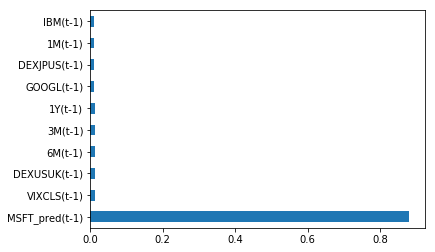

In [59]:
import pandas as pd
import numpy as np
model = RandomForestRegressor()
model.fit(X_train,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based regressors
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

<a id='6.3'></a>
## 7.3. Save Model for Later Use

In [60]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [61]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
#rescaledValidationX = scaler.transform(X_validation) #in case the data is scaled.
#predictions = model.predict(rescaledValidationX)
predictions = model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(result)

0.0010980621870578236
